In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import os
import nltk as nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycaret as pc
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model 
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import hvplot.pandas
import plotly.express as px
import datetime as dt
from pandas_profiling import ProfileReport
import seaborn  as sns
import spacy
import gensim
import plotly.graph_objects as go
import textblob   
import textstat
import pyLDAvis

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import warnings
warnings.filterwarnings('ignore')

C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
!python -m spacy download en_core_web_sm 
!python -m textblob.download_corpora

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_

In [3]:
#Create a function to read files for the Ticker Symbol

def read_file(TKR): 
    """ # Function to read file and store the output of the file content into a dictionary
         :param filename - Ticker symbol of company. Assumption is that the filename is stored as TKR.csv

    """
    filename='../Data/'+TKR+'.csv'
    
    movie_reviews= pd.read_csv(filename,parse_dates=True,usecols=np.r_[3,9:11])
            
    return movie_reviews



In [4]:
#Read Netflix Data
movie_reviews_DIS=read_file('disney')
movie_reviews_DIS.head()

critics_consensus original_release_date  \
0  One of Disney's finest live-action adventures,...              1/1/1954   
1  Robert Zemeckis' 3-D animated take on the Dick...             11/6/2009   
2  Despite hitting some sweet notes, Beverly Hill...             9/30/2008   
3  G-Force features manic action, but fails to co...             7/24/2009   
4  Its cast tries hard, but Old Dogs is a predict...            11/25/2009   

  streaming_release_date  
0              6/10/2016  
1             11/23/2015  
2             12/13/2015  
3              6/30/2016  
4               7/1/2016

#### Use critics_consensus column to view any association between this column and Stock Price movement.

##### Data Profiling

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(movie_reviews_DIS, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#We will be using original_release_date for Time series association check and critics_consensus for NLP.
#From above it shows there are rows with missing values in those fields.
#We will remove those rows.
movie_reviews_DIS = movie_reviews_DIS[movie_reviews_DIS['original_release_date'].notna()]
movie_reviews_DIS = movie_reviews_DIS[movie_reviews_DIS['critics_consensus'].notna()]

[]

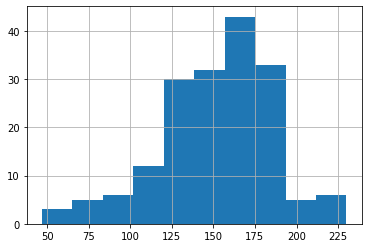

In [7]:
#Length of each comment
movie_reviews_DIS['critics_consensus'].str.len().hist().plot(kind='bar')
#Graph shows that range is between 125 and 200 characters. So we should use modules which are effective for small document size.


In [8]:
#Number of words in each comment
movie_reviews_DIS['critics_consensus'].str.split().str.len()


0      26
1      29
2      15
3      16
4      26
       ..
253    21
254    19
255    21
257    27
258    32
Name: critics_consensus, Length: 175, dtype: int64

In [9]:
#Convert Dates from object to datetime
movie_reviews_DIS[["original_release_date", "streaming_release_date"]] = movie_reviews_DIS[["original_release_date", "streaming_release_date"]].apply(pd.to_datetime)

##### We will use NLTK, GENSIM, SPACY and TEXTBLOB to do 
Date pre-processing and then check with word cloud the quality and difference in output.

In [10]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))
# Remove Stop Words
movie_reviews_DIS['critics_consensus_ntext']=movie_reviews_DIS['critics_consensus'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
movie_reviews_DIS.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


critics_consensus original_release_date  \
0  One of Disney's finest live-action adventures,...            1954-01-01   
1  Robert Zemeckis' 3-D animated take on the Dick...            2009-11-06   
2  Despite hitting some sweet notes, Beverly Hill...            2008-09-30   
3  G-Force features manic action, but fails to co...            2009-07-24   
4  Its cast tries hard, but Old Dogs is a predict...            2009-11-25   

  streaming_release_date                            critics_consensus_ntext  
0             2016-06-10  one disney's finest live-action adventures, 20...  
1             2015-11-23  robert zemeckis' 3-d animated take dickens cla...  
2             2015-12-13  despite hitting sweet notes, beverly hills chi...  
3             2016-06-30  g-force features manic action, fails come inte...  
4             2016-07-01  its cast tries hard, old dogs predictable, nea...

In [11]:
#NLTK Lemmatization
#Create function to create POS tags to be used for lemmentization.
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from collections import Counter
import re
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Complete the tokenizer function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_DIS['critics_consensus_nltktext']=movie_reviews_DIS['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
movie_reviews_DIS['critics_consensus_nltktext']=movie_reviews_DIS['critics_consensus_nltktext'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
#Replace word count with the new text
movie_reviews_DIS['wnltkcount']=movie_reviews_DIS['critics_consensus_nltktext'].str.split().str.len()
movie_reviews_DIS['hnltklength']=movie_reviews_DIS['critics_consensus_nltktext'].str.len()



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
#Lemmantization using Spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV","PROPN"]



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_DIS['critics_consensus_spacytext'] = movie_reviews_DIS['critics_consensus_ntext'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if y.pos_ in allowed_postags]))
#Replace word count with the new headline text
movie_reviews_DIS['wspacycount']=movie_reviews_DIS['critics_consensus_spacytext'].str.split().str.len()
movie_reviews_DIS['hspacylength']=movie_reviews_DIS['critics_consensus_spacytext'].str.len()



In [13]:
#Lemmantization using Gensim
import pattern
from pattern.en import lemma, lexeme
from gensim.utils import lemmatize
movie_reviews_DIS['critics_consensus_gensimtext']=movie_reviews_DIS['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
#Replace word count with the new headline text
movie_reviews_DIS['wgensimcount']=movie_reviews_DIS['critics_consensus_gensimtext'].str.split().str.len()
movie_reviews_DIS['hgensimlength']=movie_reviews_DIS['critics_consensus_gensimtext'].str.len()



In [14]:
#TextBlob Lemmatizer
from textblob import TextBlob
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
movie_reviews_DIS['critics_consensus_txtblbtext']=movie_reviews_DIS['critics_consensus_ntext'].apply(lambda x: lemmatize_with_postag(x))
#Replace word count with the new headline text
movie_reviews_DIS['wtxtblbcount']=movie_reviews_DIS['critics_consensus_txtblbtext'].str.split().str.len()
movie_reviews_DIS['htxtblblength']=movie_reviews_DIS['critics_consensus_txtblbtext'].str.len()

movie_reviews_DIS.head()

critics_consensus original_release_date  \
0  One of Disney's finest live-action adventures,...            1954-01-01   
1  Robert Zemeckis' 3-D animated take on the Dick...            2009-11-06   
2  Despite hitting some sweet notes, Beverly Hill...            2008-09-30   
3  G-Force features manic action, but fails to co...            2009-07-24   
4  Its cast tries hard, but Old Dogs is a predict...            2009-11-25   

  streaming_release_date                            critics_consensus_ntext  \
0             2016-06-10  one disney's finest live-action adventures, 20...   
1             2015-11-23  robert zemeckis' 3-d animated take dickens cla...   
2             2015-12-13  despite hitting sweet notes, beverly hills chi...   
3             2016-06-30  g-force features manic action, fails come inte...   
4             2016-07-01  its cast tries hard, old dogs predictable, nea...   

                          critics_consensus_nltktext  wnltkcount  hnltklength  \
0  one disney 's finest live-action adventure , 2...          25          147   
1  robert zemeckis ' 3-d animated take dickens cl...          23          143   
2  despite hitting sweet note , beverly hill chih...          13           92   
3  g-force feature manic action , fails come inte...          12           79   
4  cast try hard , old dog predictable , nearly w...          19          107   

                         critics_consensus_spacytext  wspacycount  \
0  disney fine live action adventure league sea b...           20   
1  robert zemeckis animate take dickens classic t...           19   
2  hit sweet note beverly hills chihuahua little ...           10   
3  g force feature manic action fail come interes...           11   
4  cast try hard old dog predictable nearly witle...           16   

   hspacylength                       critics_consensus_gensimtext  \
0           121  one disney 's finest live-action adventure , 2...   
1           131  robert zemeckis ' 3-d animated take dickens cl...   
2            77  despite hitting sweet note , beverly hill chih...   
3            73  g-force feature manic action , fails come inte...   
4           101  it cast try hard , old dog predictable , nearl...   

   wgensimcount  hgensimlength  \
0            26            153   
1            23            143   
2            13             92   
3            12             79   
4            20            110   

                        critics_consensus_txtblbtext  wtxtblbcount  \
0  one disney 's fine live-action adventure 20,00...            23   
1  robert zemeckis ' 3-d animated take dickens cl...            21   
2  despite hit sweet note beverly hill chihuahua ...            11   
3  g-force feature manic action fail come interes...            10   
4  it cast try hard old dog predictable nearly wi...            17   

   htxtblblength  
0            145  
1            137  
2             84  
3             70  
4            104

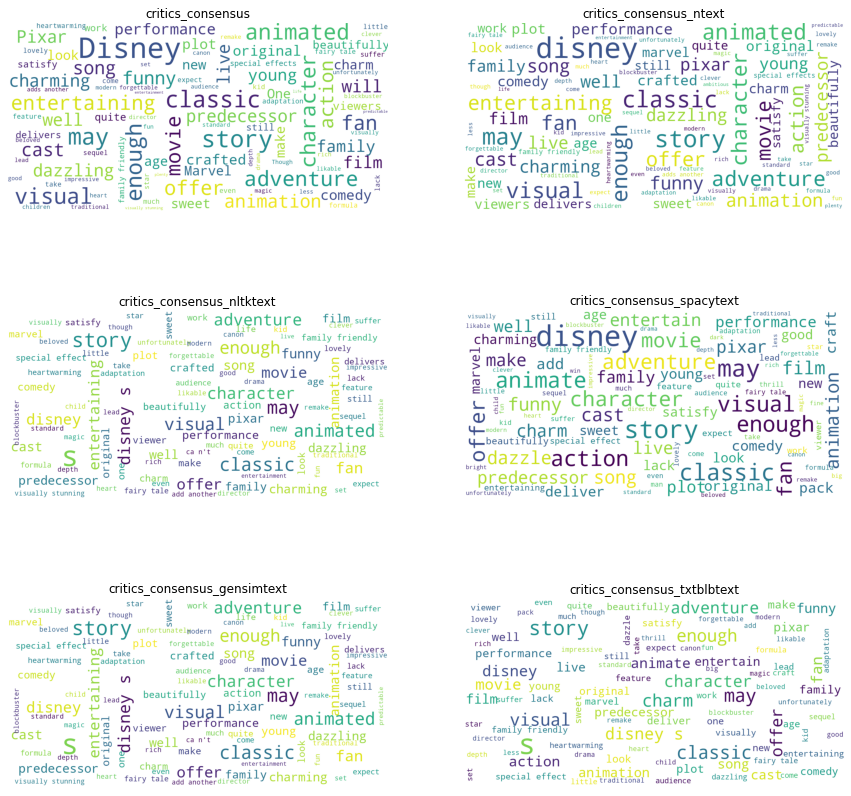

In [15]:
#Word clouds for each of the Lemmatizer

fig = plt.figure(1, figsize=(15, 15))
for i in range(len(movie_reviews_DIS.columns[movie_reviews_DIS.dtypes==object])):
    ax = fig.add_subplot( int(len(movie_reviews_DIS.columns[movie_reviews_DIS.dtypes==object])/2),2,i+1)
    
    column=movie_reviews_DIS.columns[movie_reviews_DIS.dtypes==object][i]
    
    words = ' '.join(movie_reviews_DIS[column])
    
    wordcloud = WordCloud(
                      background_color='white', 
                      max_words=100,
                      max_font_size=30,
                      scale=3,
                      random_state=1
                     ).generate(words)
    ax.title.set_text(movie_reviews_DIS.columns[movie_reviews_DIS.dtypes==object][i])
    ax.imshow(wordcloud)
    ax.axis('off')

It seems like Spacy is performing the best as seen by big words.

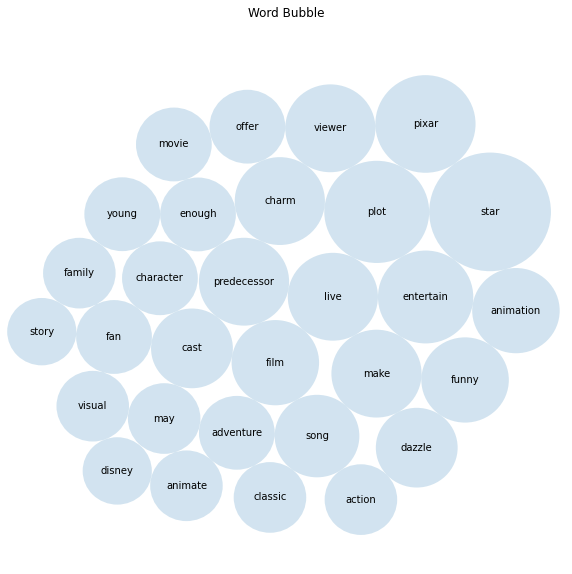

In [16]:
#Word Bubbles
#We will use SpacyText to see the word distribution in a form other than wordcloud to confirm and surprisingly 
# the output is totatly different.

import circlify

def df_create_bubble(document):
    
   
    word_counts = Counter()

    document.str.lower().str.split().apply(lambda x: [w.strip() for w in x if w.strip() not in stop]).apply(word_counts.update)

    
    # settings for treemap
    common_n = [n for (w, n) in word_counts.most_common(30)] # top30 words' counts
    common_w = [w for (w, n) in word_counts.most_common(30)] # top30 words
    keywords = pd.DataFrame(word_counts.most_common(30), columns = ['Words', 'Freq'])
    
    return keywords

df_bubble=df_create_bubble(movie_reviews_DIS['critics_consensus_spacytext'])


# compute circle positions:
circles = circlify.circlify(
    df_bubble['Freq'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)



# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Word Bubble')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = df_bubble['Words']

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )

#### Stock Data Extraction and Profiling

In [17]:
# Obtain Keys to connect to ALPACA API
load_dotenv() # True
CONSUMER_KEY = os.environ.get("ALPACA_API_KEY")

CONSUMER_SECRET_KEY = os.environ.get("ALPACA_SECRET_KEY")
#quandl.ApiConfig.api_key = os.environ.get("QUANTA_API_KEY")

In [18]:
# Initialize ALPACA API
ALPACA_URL='https://paper-api.alpaca.markets'
alpaca_api = tradeapi.REST(CONSUMER_KEY, CONSUMER_SECRET_KEY, ALPACA_URL, api_version='v2')

In [19]:
# Call ALPACA API to get data for ticker symbols.
# Format current date as ISO format
NY = 'America/New_York'

edate = dt.date.today()
start=pd.Timestamp('2010-01-01', tz=NY).isoformat()
end=pd.Timestamp(edate, tz=NY).isoformat()
# Set the tickers
tickers = ["DIS"]
# Set timeframe to '1D' for Alpaca API, 
# Get current closing prices for SPY and Ticker 
# (use a limit=1000 parameter to call the most recent 1000 days of data)
alpaca_api.get_bars(tickers, '1D', start=start, end=end, limit=1000).df

open     high       low   close    volume  \
timestamp                                                                
2015-12-01 05:00:00+00:00  114.03  115.460  113.6600  115.39   8897325   
2015-12-02 05:00:00+00:00  115.39  115.470  113.8300  114.00   7788669   
2015-12-03 05:00:00+00:00  114.00  114.651  111.4400  111.89  10446887   
2015-12-04 05:00:00+00:00  112.66  114.305  112.5300  114.24   8771397   
2015-12-07 05:00:00+00:00  114.40  114.560  112.6500  113.83   6738650   
...                           ...      ...       ...     ...       ...   
2019-11-13 05:00:00+00:00  138.58  149.920  136.8400  148.72  46494217   
2019-11-14 05:00:00+00:00  148.29  150.630  146.2765  147.15  28422730   
2019-11-15 05:00:00+00:00  146.93  147.200  144.2100  144.67  13749419   
2019-11-18 05:00:00+00:00  144.75  149.040  143.6900  147.65  15356968   
2019-11-19 05:00:00+00:00  148.00  149.480  146.8000  148.38  11510128   

                           trade_count        vwap symbol  
timestamp                                                  
2015-12-01 05:00:00+00:00        59354  114.998268    DIS  
2015-12-02 05:00:00+00:00        56554  114.350238    DIS  
2015-12-03 05:00:00+00:00        71382  112.502550    DIS  
2015-12-04 05:00:00+00:00        60467  113.726958    DIS  
2015-12-07 05:00:00+00:00        48083  113.500726    DIS  
...                                ...         ...    ...  
2019-11-13 05:00:00+00:00       360818  144.914887    DIS  
2019-11-14 05:00:00+00:00       216283  148.248032    DIS  
2019-11-15 05:00:00+00:00       115679  145.250718    DIS  
2019-11-18 05:00:00+00:00       131998  147.353239    DIS  
2019-11-19 05:00:00+00:00        84336  148.289790    DIS  

[1000 rows x 8 columns]

In [20]:
#Create dataframe to store API output
DIS_DF=alpaca_api.get_bars(tickers, '1D', start=start, end=end, limit=1000).df
DIS_DF.head()

open     high     low   close    volume  \
timestamp                                                              
2015-12-01 05:00:00+00:00  114.03  115.460  113.66  115.39   8897325   
2015-12-02 05:00:00+00:00  115.39  115.470  113.83  114.00   7788669   
2015-12-03 05:00:00+00:00  114.00  114.651  111.44  111.89  10446887   
2015-12-04 05:00:00+00:00  112.66  114.305  112.53  114.24   8771397   
2015-12-07 05:00:00+00:00  114.40  114.560  112.65  113.83   6738650   

                           trade_count        vwap symbol  
timestamp                                                  
2015-12-01 05:00:00+00:00        59354  114.998268    DIS  
2015-12-02 05:00:00+00:00        56554  114.350238    DIS  
2015-12-03 05:00:00+00:00        71382  112.502550    DIS  
2015-12-04 05:00:00+00:00        60467  113.726958    DIS  
2015-12-07 05:00:00+00:00        48083  113.500726    DIS

In [21]:
DIS_DF['Daily Return'] = DIS_DF['close'].pct_change(1)
DIS_DF.head()

open     high     low   close    volume  \
timestamp                                                              
2015-12-01 05:00:00+00:00  114.03  115.460  113.66  115.39   8897325   
2015-12-02 05:00:00+00:00  115.39  115.470  113.83  114.00   7788669   
2015-12-03 05:00:00+00:00  114.00  114.651  111.44  111.89  10446887   
2015-12-04 05:00:00+00:00  112.66  114.305  112.53  114.24   8771397   
2015-12-07 05:00:00+00:00  114.40  114.560  112.65  113.83   6738650   

                           trade_count        vwap symbol  Daily Return  
timestamp                                                                
2015-12-01 05:00:00+00:00        59354  114.998268    DIS           NaN  
2015-12-02 05:00:00+00:00        56554  114.350238    DIS     -0.012046  
2015-12-03 05:00:00+00:00        71382  112.502550    DIS     -0.018509  
2015-12-04 05:00:00+00:00        60467  113.726958    DIS      0.021003  
2015-12-07 05:00:00+00:00        48083  113.500726    DIS     -0.003589

<AxesSubplot:xlabel='timestamp'>

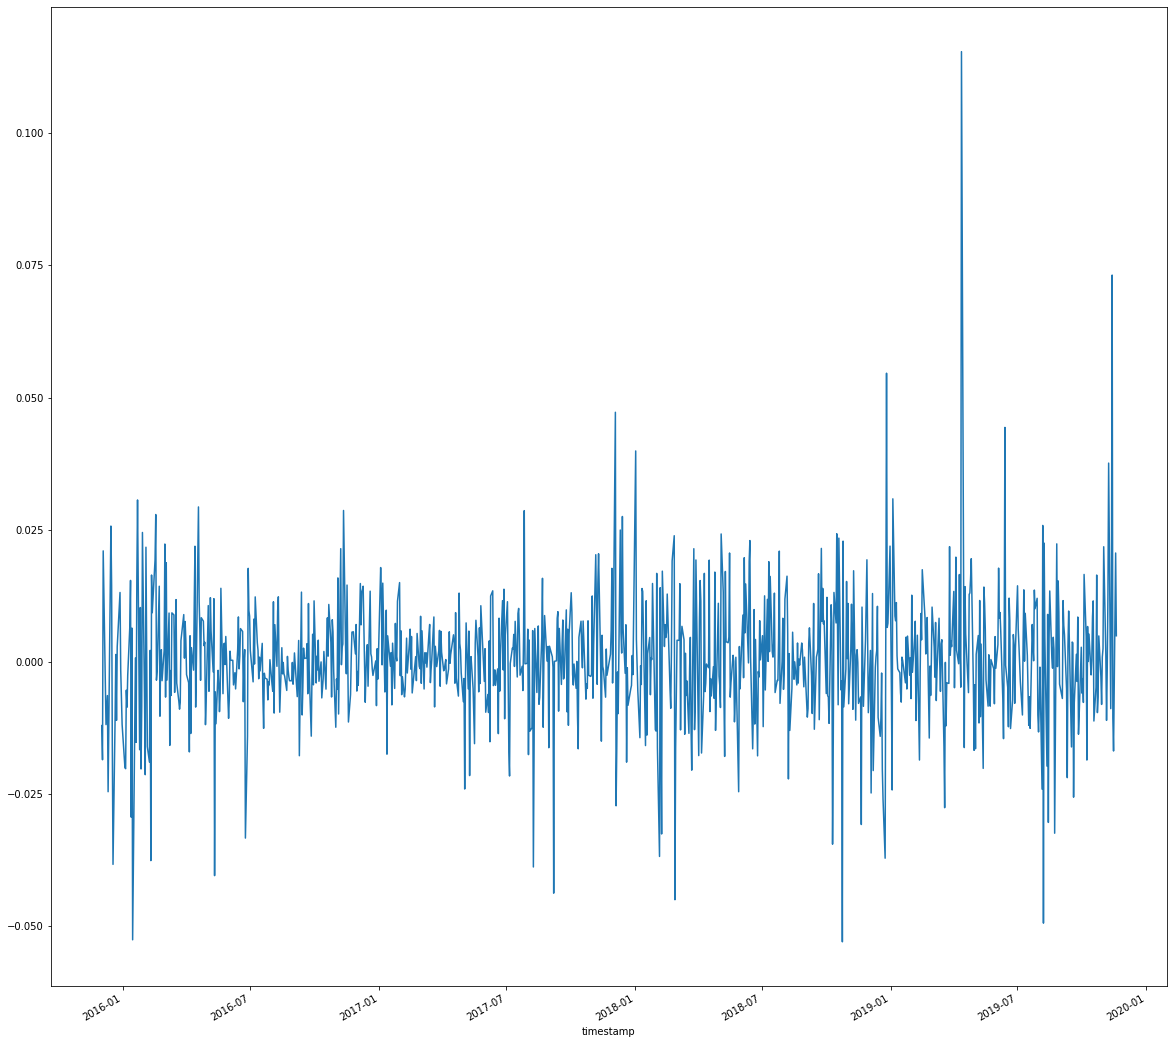

In [22]:
# Plot daily returns 
DIS_DF['Daily Return'].plot(figsize=(20, 20))

<AxesSubplot:xlabel='timestamp'>

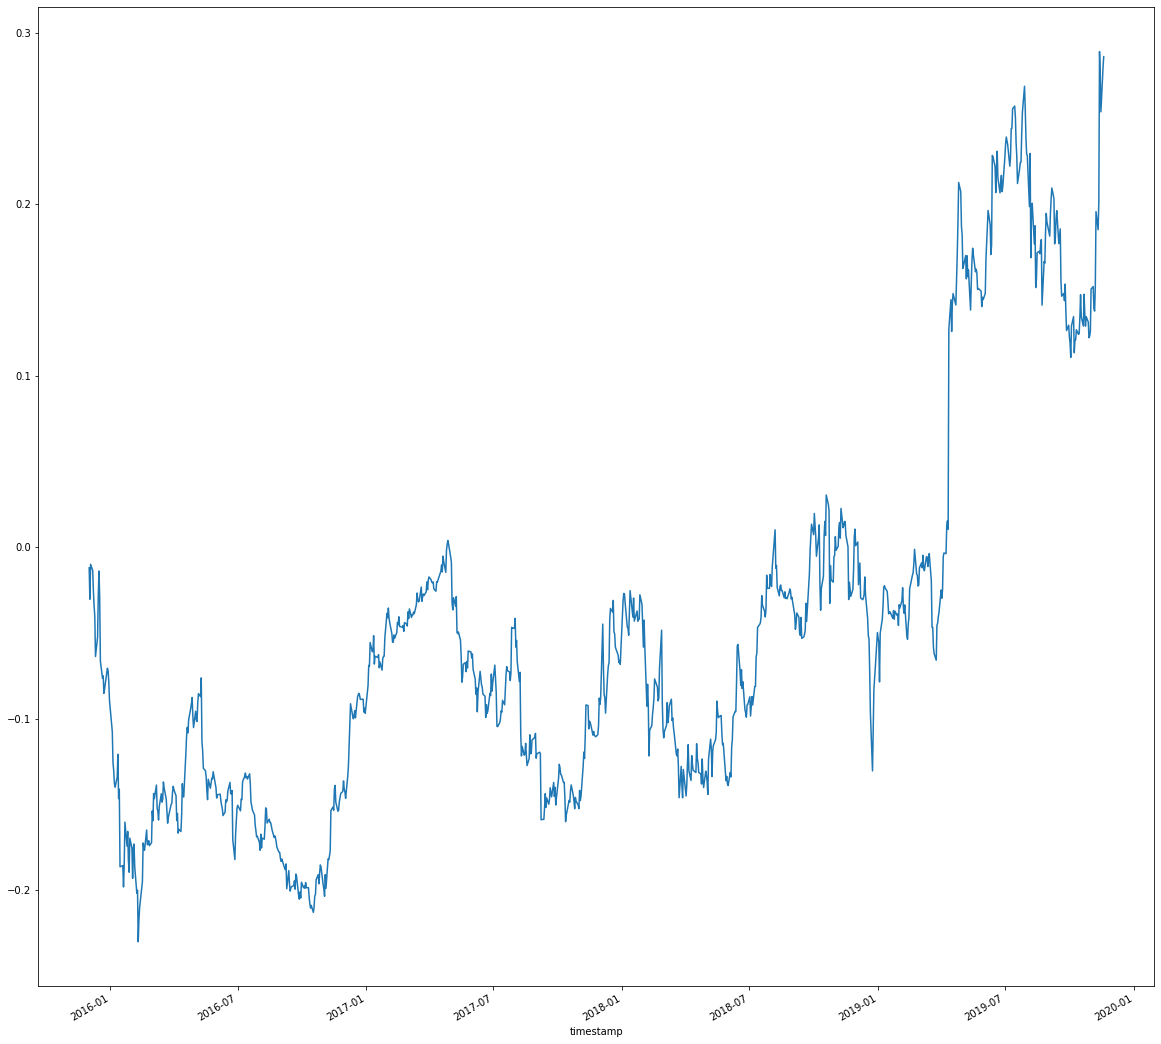

In [23]:
# Calculate cumulative returns 

# Plot cumulative returns
((DIS_DF['Daily Return'] + 1).cumprod() - 1).plot(figsize=(20, 20))

<AxesSubplot:xlabel='timestamp'>

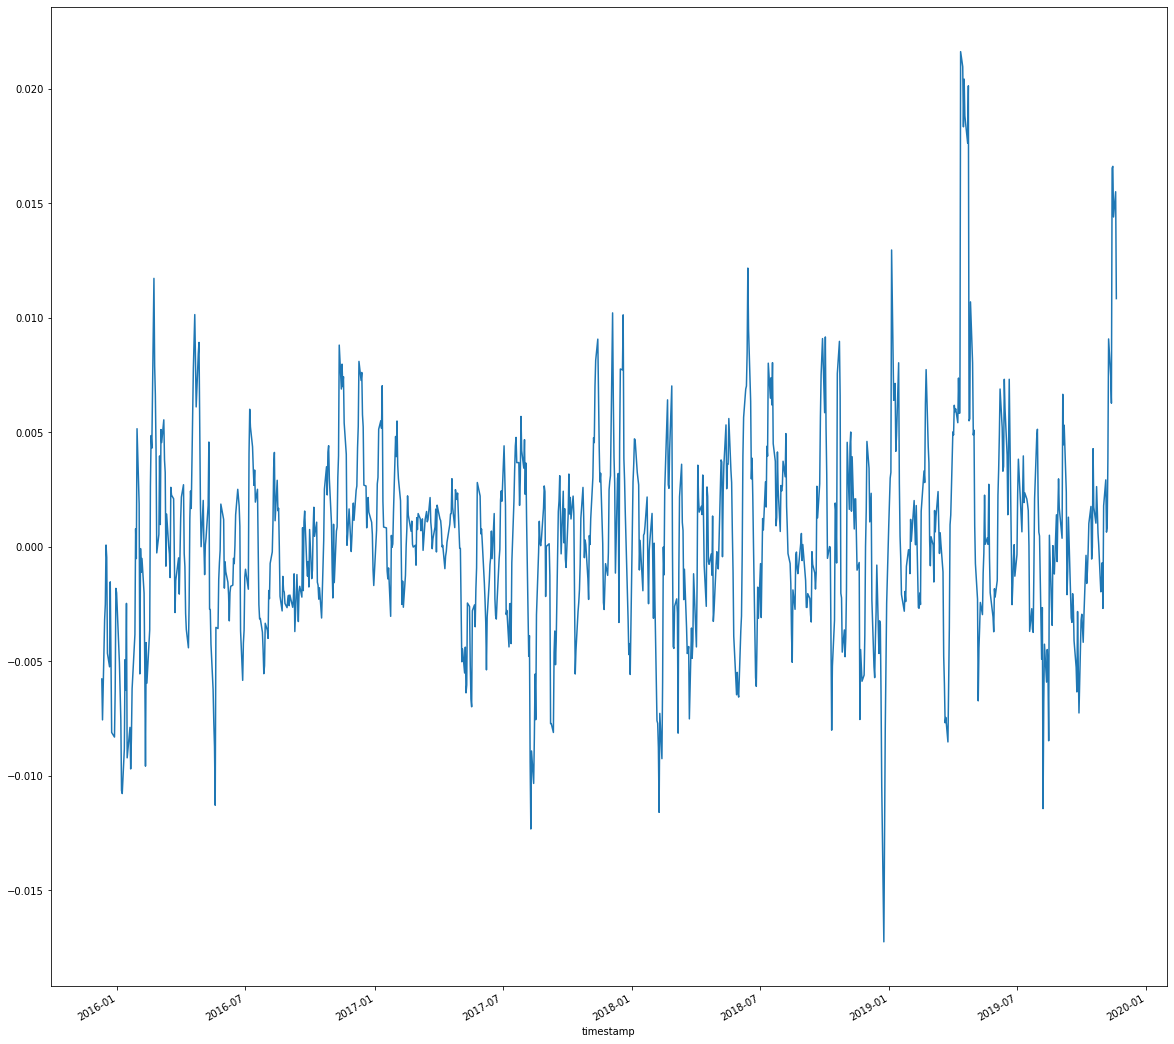

In [24]:
# Plot a rolling 7-day mean of DIS_DF's Daily Return
DIS_DF['Daily Return'].rolling(window = 7).mean().plot(figsize=(20, 20))

##### Back to NLP, we will generate Sentiment polarity score using a new library FLAIR

In [25]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-05-06 13:14:21,996 loading file C:\Users\BalleBalle\.flair\models\sentiment-en-mix-distillbert_4.pt


In [26]:
# we will append probability and sentiment preds later
probs = []
sentiments = []

for comment in movie_reviews_DIS['critics_consensus_spacytext'].to_list():
    # make prediction
    sentence = flair.data.Sentence(comment)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# add probability and sentiment predictions to tweets dataframe
movie_reviews_DIS['Flair_Score_draft'] = probs
movie_reviews_DIS['sentiment_flair'] = sentiments

In [27]:
# Convert the Flair score to show the sign of the value.
movie_reviews_DIS['Flair_Score']= movie_reviews_DIS['sentiment_flair'].apply(lambda x: '-' if (x == 'NEGATIVE') else '') 

movie_reviews_DIS['Flair_Score'] = movie_reviews_DIS['Flair_Score'] + movie_reviews_DIS['Flair_Score_draft'].astype(str)
movie_reviews_DIS['Flair_Score'] = pd.to_numeric(movie_reviews_DIS['Flair_Score'], errors='coerce')

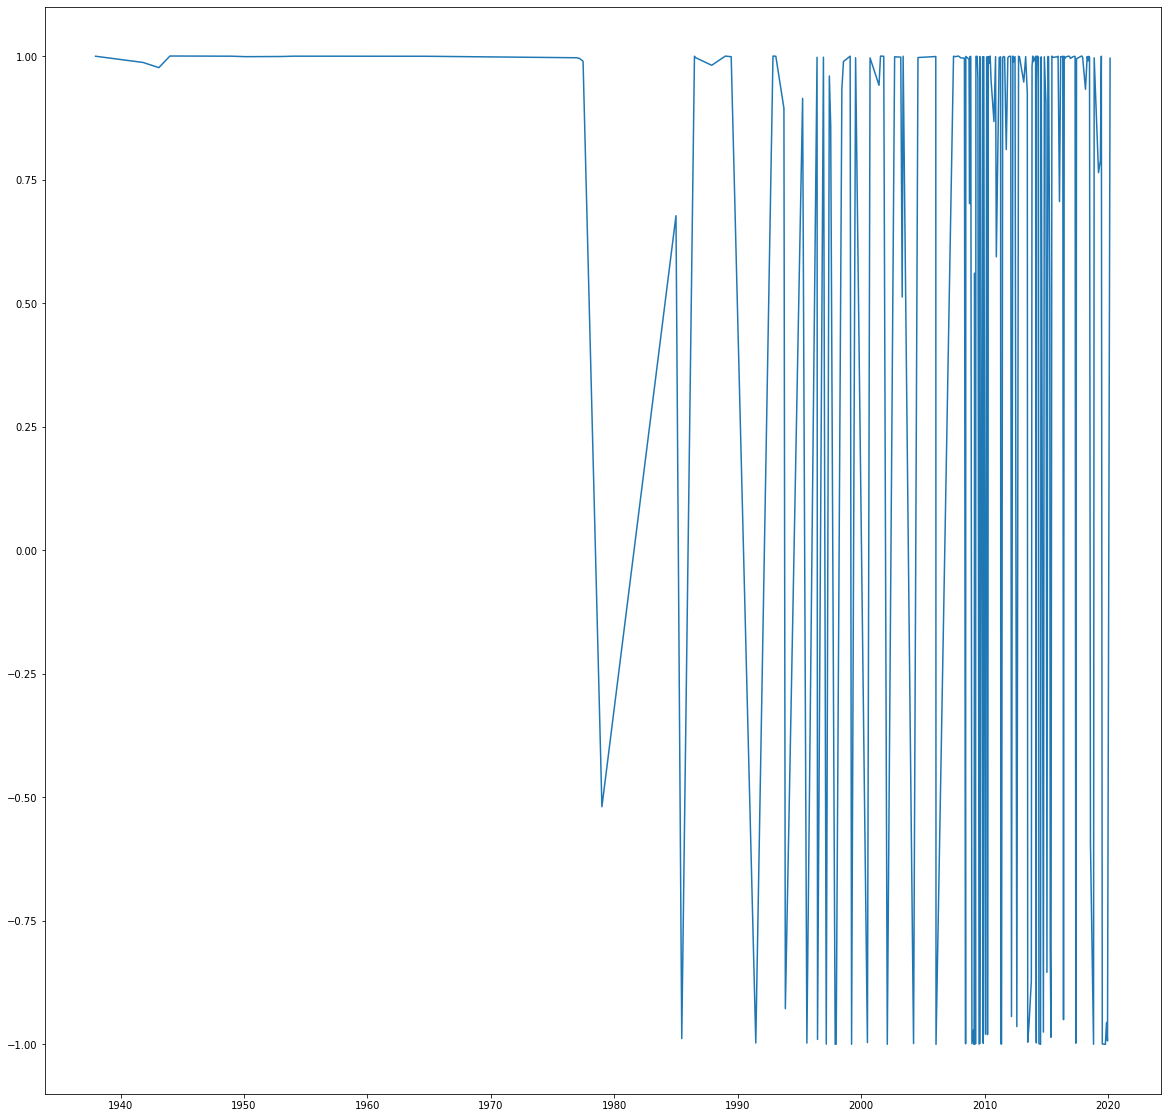

In [28]:
# Plot spacy cleaned critic_consensus score with time
#movie_reviews_DIS['probabilityS-spacy'] .plot(figsize=(20, 20))
movie_reviews_DIS = movie_reviews_DIS.sort_values('original_release_date', ascending=True)
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(movie_reviews_DIS['original_release_date'], movie_reviews_DIS['Flair_Score'])

In [29]:
#Compare with VADER
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiments_netflix = []#creates empty list

#Going to use VADER’s SentimentIntensityAnalyzer() to see how many 'Neutral (neu)' , 'Positive (pos)', and 'Negatvie(neg)'
# words there are for each article. 
for articles in movie_reviews_DIS['critics_consensus_spacytext']: #goes through each artilce in df and applies polarity
    try:
        text = articles #accessing each articles 'content' which contains the article itself in 'bitcoin_news'
        results = analyzer.polarity_scores(text) #this is how get compound, pos, neg, and nue polarity scores
        #during imports we set analyzer equal to SentimentIntensityAnalyzer() 
        #'results' uses this function to find polarity score for each article in bitcoin_news
        compound = results["compound"] #gets compound polarity score
        pos = results["pos"] #gets postive polarity score
        neu = results["neu"] #gets neutral polarity score
        neg = results["neg"] #gets negative polarity score

        sentiments_netflix.append({
            "text": text,
            "NLTK_Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu,
        }) #appends a dictionary inside the list-(sentiments) so a dataframe can be created
        #this appends all polarity score we got above
    except AttributeError:
        pass
#rinse and repeat for each article    
netflix = pd.DataFrame(sentiments_netflix)#creates a dataframe using the list of dicts
#netflix = netflix.join(netflix_df['movie_title'])
#netflix = netflix.join(netflix_df['original_release_date'])
#netflix = netflix.join(netflix_df['streaming_release_date'])
movie_reviews_DIS=movie_reviews_DIS.join(netflix['NLTK_Compound'])
#netflix = netflix.drop(columns = ['Positive', 'Negative', 'Neutral'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
movie_reviews_DIS.head()

critics_consensus original_release_date  \
18   With its involving story and characters, vibra...            1937-12-21   
89   Dumbo packs plenty of story into its brief run...            1941-10-23   
186  One of Disney's lesser-known animated films, S...            1943-02-06   
234  One of Disney's more abstract creations, The T...            1944-01-01   
32   This Disney two-fer may not be the most revere...            1949-01-01   

    streaming_release_date                            critics_consensus_ntext  \
18              2016-09-01  with involving story characters, vibrant art, ...   
89              2015-12-13  dumbo packs plenty story brief runtime, along ...   
186             2016-05-13  one disney's lesser-known animated films, salu...   
234             2016-05-13  one disney's abstract creations, the three cab...   
32              2016-05-06  this disney two-fer may reverent literary adap...   

                            critics_consensus_nltktext  wnltkcount  \
18   involving story character , vibrant art , memo...          20   
89   dumbo pack plenty story brief runtime , along ...          16   
186  one disney 's lesser-known animated film , sal...          19   
234  one disney 's abstract creation , three caball...          17   
32   disney two-fer may reverent literary adaptatio...          12   

     hnltklength                        critics_consensus_spacytext  \
18           118  involve story character vibrant art memorable ...   
89           100  dumbo packs plenty story brief runtime warm an...   
186          115  disney lesser know animate film saludos amigo ...   
234          107  disney abstract creation caballero dazzle colo...   
32            91  disney fer may reverent literary adaptation re...   

     wspacycount  hspacylength  \
18            15           103   
89            13            91   
186           14            98   
234           11            85   
32            10            81   

                          critics_consensus_gensimtext  wgensimcount  \
18   with involving story character , vibrant art ,...            21   
89   dumbo pack plenty story brief runtime , along ...            16   
186  one disney 's lesser-known animated film , sal...            19   
234  one disney 's abstract creation , the three ca...            18   
32   this disney two-fer may reverent literary adap...            13   

     hgensimlength                       critics_consensus_txtblbtext  \
18             123  with involve story character vibrant art memor...   
89             100  dumbo pack plenty story brief runtime along wa...   
186            115  one disney 's lesser-known animated film salud...   
234            111  one disney 's abstract creation the three caba...   
32              96  this disney two-fer may reverent literary adap...   

     wtxtblbcount  htxtblblength  Flair_Score_draft sentiment_flair  \
18             17            113           0.999497        POSITIVE   
89             14             96           0.986971        POSITIVE   
186            15            105           0.976459        POSITIVE   
234            15            103           0.999941        POSITIVE   
32             11             90           0.999599        POSITIVE   

     Flair_Score  NLTK_Compound  
18      0.999497         0.8360  
89      0.986971        -0.4019  
186     0.976459            NaN  
234     0.999941            NaN  
32      0.999599         0.2748

In [31]:
#Check TextBlob Sentiment score too
#movie_reviews_DIS['score_txtblob'] = movie_reviews_DIS['critics_consensus_spacytext'].apply(lambda Text: TextBlob(Text).sentiment)
movie_reviews_DIS[['score_txtblob','subj_txtblob']] = movie_reviews_DIS['critics_consensus_spacytext'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [32]:
movie_reviews_DIS.head()

critics_consensus original_release_date  \
18   With its involving story and characters, vibra...            1937-12-21   
89   Dumbo packs plenty of story into its brief run...            1941-10-23   
186  One of Disney's lesser-known animated films, S...            1943-02-06   
234  One of Disney's more abstract creations, The T...            1944-01-01   
32   This Disney two-fer may not be the most revere...            1949-01-01   

    streaming_release_date                            critics_consensus_ntext  \
18              2016-09-01  with involving story characters, vibrant art, ...   
89              2015-12-13  dumbo packs plenty story brief runtime, along ...   
186             2016-05-13  one disney's lesser-known animated films, salu...   
234             2016-05-13  one disney's abstract creations, the three cab...   
32              2016-05-06  this disney two-fer may reverent literary adap...   

                            critics_consensus_nltktext  wnltkcount  \
18   involving story character , vibrant art , memo...          20   
89   dumbo pack plenty story brief runtime , along ...          16   
186  one disney 's lesser-known animated film , sal...          19   
234  one disney 's abstract creation , three caball...          17   
32   disney two-fer may reverent literary adaptatio...          12   

     hnltklength                        critics_consensus_spacytext  \
18           118  involve story character vibrant art memorable ...   
89           100  dumbo packs plenty story brief runtime warm an...   
186          115  disney lesser know animate film saludos amigo ...   
234          107  disney abstract creation caballero dazzle colo...   
32            91  disney fer may reverent literary adaptation re...   

     wspacycount  hspacylength  ... hgensimlength  \
18            15           103  ...           123   
89            13            91  ...           100   
186           14            98  ...           115   
234           11            85  ...           111   
32            10            81  ...            96   

                          critics_consensus_txtblbtext  wtxtblbcount  \
18   with involve story character vibrant art memor...            17   
89   dumbo pack plenty story brief runtime along wa...            14   
186  one disney 's lesser-known animated film salud...            15   
234  one disney 's abstract creation the three caba...            15   
32   this disney two-fer may reverent literary adap...            11   

    htxtblblength  Flair_Score_draft  sentiment_flair  Flair_Score  \
18            113           0.999497         POSITIVE     0.999497   
89             96           0.986971         POSITIVE     0.986971   
186           105           0.976459         POSITIVE     0.976459   
234           103           0.999941         POSITIVE     0.999941   
32             90           0.999599         POSITIVE     0.999599   

    NLTK_Compound  score_txtblob  subj_txtblob  
18         0.8360       0.166667      0.333333  
89        -0.4019       0.441667      0.525000  
186           NaN       0.208333      0.541667  
234           NaN       0.316667      0.700000  
32         0.2748       0.283333      0.500000  

[5 rows x 22 columns]

<AxesSubplot:xlabel='Flair_Score', ylabel='score_txtblob'>

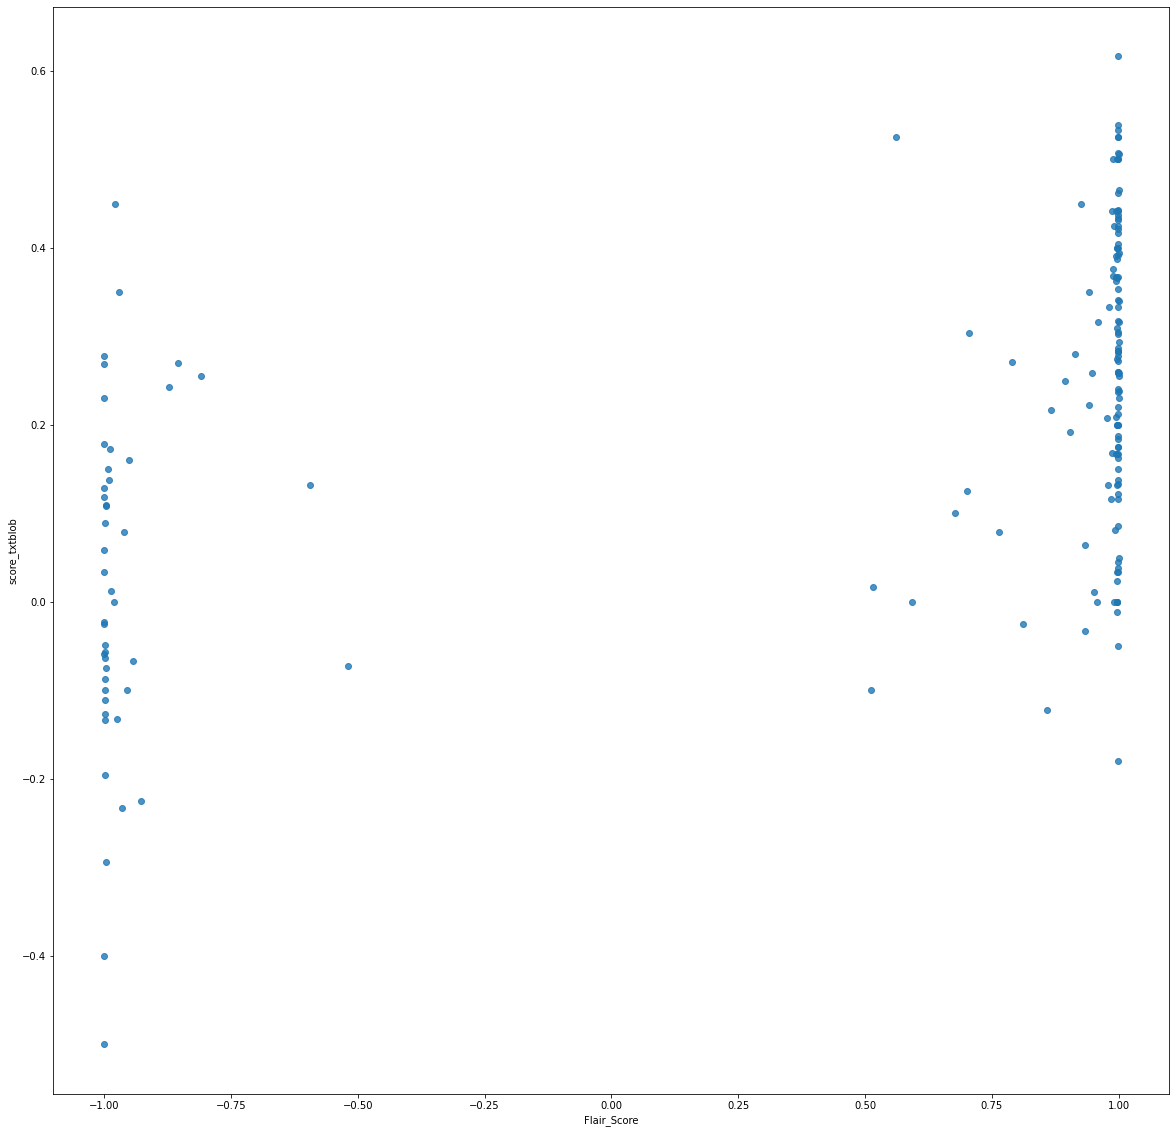

In [40]:
#scatter plot of the Pearson correlation coefficient between the mentioned two algorithms Flair and TextBlob
import seaborn as sns

# use the function regplot to make a scatterplot
sns.regplot(x=movie_reviews_DIS["Flair_Score"], y=movie_reviews_DIS["score_txtblob"], fit_reg=False)

There seems to be some outliers.
Where Flair is calling a comment as positive, TextBlob is calling it negative.
And where Flair is calling it a negative, TextBlob is calling is a low positive.

Manually looking at the data, it seems Flair gives better output.
Using Flair score for our scenario.

#### Granger Causality test
The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.
This test uses the following null and alternative hypotheses:
Null Hypothesis (H0): Time series x does not Granger-cause time series y
Alternative Hypothesis (HA): Time series x Granger-causes time series y
The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful for 
predicting the value of time series y at a later time period.
Source: https://www.statology.org/granger-causality-test-in-python/
        
A prerequisite for performing the Granger Causality test is that the data need to be stationary i.e 
it should have a constant mean, constant variance, and no seasonal component. Transform the non-stationary 
data to stationary data by differencing it, either first-order or second-order differencing. 

There are number of tests available to validate Time series stationary characterstics,

Augmented Dickey Fuller test (ADH Test)
Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [33]:
#We will use ADH Test on Netflix daily returns 
DIS_DF = DIS_DF[DIS_DF['Daily Return'].notna()]
# Daily Returns
from statsmodels.tsa.stattools import adfuller


# ADF Test
result = adfuller(DIS_DF['Daily Return'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    


ADF Statistic: -17.61345336940992
p-value: 3.869539377626351e-30
Critial Values:
   1%, -3.4369325637409154
Critial Values:
   5%, -2.8644462162311934
Critial Values:
   10%, -2.568317409920808


Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can be rejected.
Hence, the series is stationary.

In [34]:
#Since the series is stationaru, we will now apply the Granger Causality test.
#### Data Preprocessing for test
#1. Form both data sets matching the same dates
#2. Merge the resulting data frames on date.

# Netflix critic comment data pre-processing
# We will use Flair score 
DIS_mov_df=movie_reviews_DIS[['original_release_date','Flair_Score']]

# Netflix daily return pre-processing
DIS_DF.reset_index(inplace=True)
dis_stk_df=DIS_DF[['timestamp','Daily Return']]
dis_stk_df['date']=dis_stk_df['timestamp'].dt.date
#Convert Dates from object to datetime
dis_stk_df[["date"]] = dis_stk_df[["date"]].apply(pd.to_datetime)
dis_stk_df.drop('timestamp', axis=1, inplace=True) 
dis_stk_df = dis_stk_df[['date', 'Daily Return']]

In [35]:
display(DIS_mov_df)

display(dis_stk_df)

original_release_date  Flair_Score
18             1937-12-21     0.999497
89             1941-10-23     0.986971
186            1943-02-06     0.976459
234            1944-01-01     0.999941
32             1949-01-01     0.999599
..                    ...          ...
223            2019-07-19    -0.999203
137            2019-10-18    -0.999877
101            2019-11-21    -0.955690
201            2019-12-20    -0.993043
158            2020-03-06     0.995453

[175 rows x 2 columns]

date  Daily Return
0   2015-12-02     -0.012046
1   2015-12-03     -0.018509
2   2015-12-04      0.021003
3   2015-12-07     -0.003589
4   2015-12-08     -0.011860
..         ...           ...
994 2019-11-13      0.073171
995 2019-11-14     -0.010557
996 2019-11-15     -0.016854
997 2019-11-18      0.020599
998 2019-11-19      0.004944

[999 rows x 2 columns]

In [36]:
# Join the two dataframes
Final_df = pd.merge(DIS_mov_df, dis_stk_df, how="inner", left_on="original_release_date", right_on="date").drop(["date"], axis=1)
Final_df.set_index('original_release_date',inplace=True)

In [37]:
Final_df.shape

(32, 2)

<AxesSubplot:xlabel='original_release_date'>

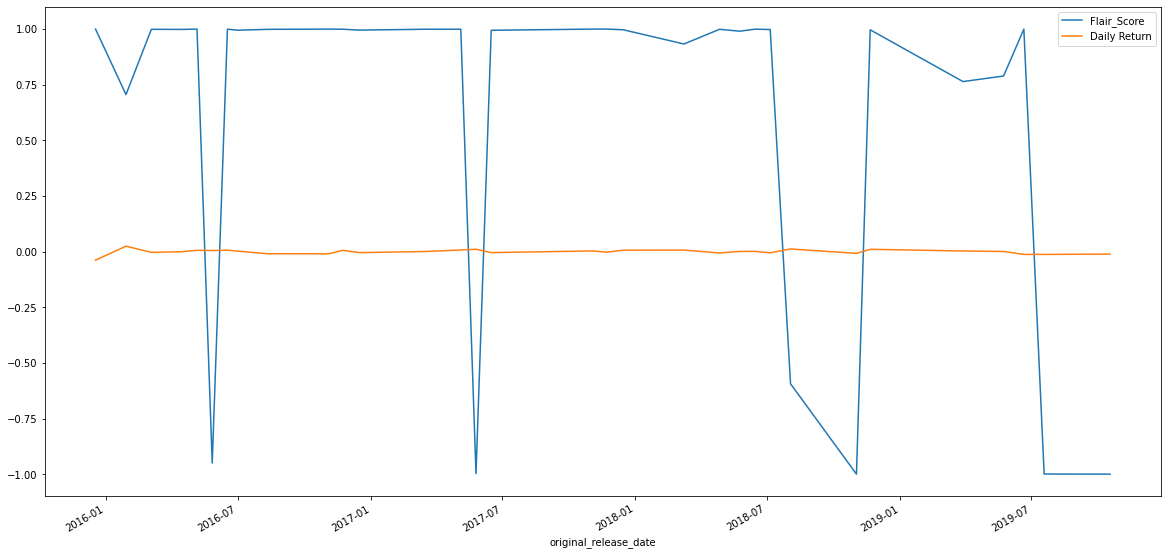

In [38]:
#Plot both columns against Release Date
Final_df.plot(figsize=(20, 10))

### Apply the Granger Casuality test



It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X)
is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the 
P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said 
lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.




In [39]:
from statsmodels.tsa.stattools import grangercausalitytests
#perform Granger-Causality test
grangercausalitytests(Final_df[['Daily Return', 'Flair_Score']], maxlag=[7])


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3313  , p=0.3289  , df_denom=10, df_num=7
ssr based chi2 test:   chi2=23.2973 , p=0.0015  , df=7
likelihood ratio test: chi2=16.4625 , p=0.0212  , df=7
parameter F test:         F=1.3313  , p=0.3289  , df_denom=10, df_num=7


{7: ({'ssr_ftest': (1.3312732373089478, 0.32894309689887014, 10.0, 7),
   'ssr_chi2test': (23.297281652906587, 0.0015127961911869598, 7),
   'lrtest': (16.46248634320989, 0.021211064963722798, 7),
   'params_ftest': (1.3312732373089857, 0.3289430968988558, 10.0, 7.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

#### Following the above process for TXTBlob Score and Stock correlation check.

In [41]:
# TXTBLOB DISNEY
#data frames for each score
DIS_mov_df_txtblob = movie_reviews_DIS[['original_release_date','score_txtblob']] #dataframe
DIS_mov_df_nltk = movie_reviews_DIS[['original_release_date','NLTK_Compound']] #dataframe






In [42]:
# Join the stock and textblob score dataframes
Final_df_txtblob = pd.merge(DIS_mov_df_txtblob, dis_stk_df, how="inner", left_on="original_release_date", right_on="date").drop(["date"], axis=1)
Final_df_txtblob.set_index('original_release_date',inplace=True)

In [43]:
#Join the stock and NLTK score
Final_df_nltk = pd.merge(DIS_mov_df_nltk, dis_stk_df, how="inner", left_on="original_release_date", right_on="date").drop(["date"], axis=1)
Final_df_nltk.set_index('original_release_date',inplace=True)

<AxesSubplot:xlabel='original_release_date'>

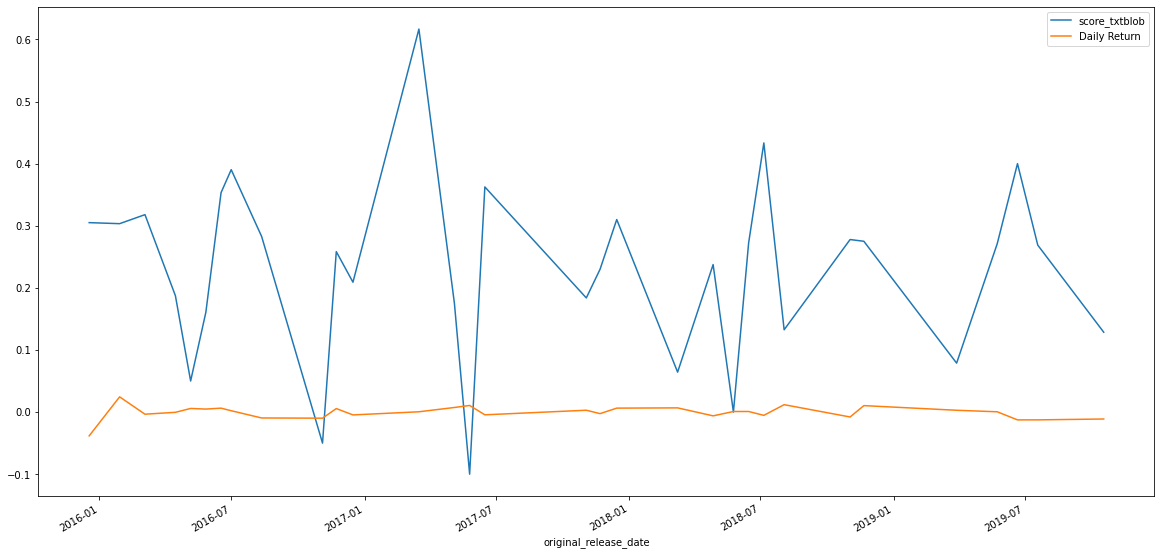

In [44]:
# plotting these
Final_df_txtblob.plot(figsize=(20, 10))


In [45]:
#perform Granger-Causality test
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(Final_df_txtblob[['Daily Return', 'score_txtblob']], maxlag=[7])



Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8040  , p=0.6026  , df_denom=10, df_num=7
ssr based chi2 test:   chi2=14.0705 , p=0.0499  , df=7
likelihood ratio test: chi2=11.1623 , p=0.1317  , df=7
parameter F test:         F=0.8040  , p=0.6026  , df_denom=10, df_num=7


{7: ({'ssr_ftest': (0.8040291223476771, 0.6025705063445379, 10.0, 7),
   'ssr_chi2test': (14.070509641084351, 0.0499413885340631, 7),
   'lrtest': (11.162303210523874, 0.13169445032721594, 7),
   'params_ftest': (0.8040291223476651, 0.6025705063445458, 10.0, 7.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

#### Conclusion
In the above case P-Value is indeed above 0.05 and hence we can assume that the critic comments do not impact stock value.

We should further test with different publishing company and much bigger dataset.